In [10]:


import sys, types
import numpy as np
from sklearn.datasets import make_moons, make_circles


def make_xor(n, rng, noise=0.15):
    X = rng.uniform(-1, 1, (n, 2))
    y = (X[:,0] * X[:,1] > 0).astype(int)
    X += rng.normal(0, noise, size=X.shape)
    return X, y

def make_spirals(n, rng, noise=0.08, turns=3):
    n2 = n // 2
    theta = np.linspace(0, turns * 2*np.pi, n2)
    r = np.linspace(0.0, 1.0, n2)
    x1 = np.c_[r*np.cos(theta), r*np.sin(theta)]
    x2 = np.c_[r*np.cos(theta + np.pi), r*np.sin(theta + np.pi)]
    X = np.vstack([x1, x2]) + rng.normal(0, noise, size=(2*n2, 2))
    y = np.hstack([np.zeros(n2, int), np.ones(n2, int)])
    return X, y

def make_rings(n, rng, noise=0.05):
    n2 = n // 2
    angles1 = rng.uniform(0, 2*np.pi, n2)
    angles2 = rng.uniform(0, 2*np.pi, n2)
    r1 = rng.normal(0.5, noise, n2)
    r2 = rng.normal(1.0, noise, n2)
    x1 = np.c_[r1*np.cos(angles1), r1*np.sin(angles1)]
    x2 = np.c_[r2*np.cos(angles2), r2*np.sin(angles2)]
    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n2, int), np.ones(n2, int)])
    return X, y

def make_checker(n, rng, noise=0.03, tiles=6):
    s = int(np.sqrt(n))
    x1 = np.linspace(-1, 1, s)
    x2 = np.linspace(-1, 1, s)
    XX, YY = np.meshgrid(x1, x2)
    X = np.c_[XX.ravel(), YY.ravel()]
    y = (((np.floor((XX+1)*tiles/2) + np.floor((YY+1)*tiles/2)) % 2) > 0).astype(int).ravel()
    X += rng.normal(0, noise, size=X.shape)   # jitter
    idx = rng.choice(len(X), size=n, replace=True)
    return X[idx], y[idx]



def load_dataset(kind, n, rng):

    if kind == "moons":
        return make_moons(n_samples=n, noise=0.25, random_state=0)

    if kind == "circles":
        return make_circles(n_samples=n, noise=0.1, factor=0.5, random_state=0)

    if kind == "xor":
        return make_xor(n, rng)

    if kind == "spirals":
        return make_spirals(n, rng)

    if kind == "rings":
        return make_rings(n, rng)

    if kind == "checker":
        return make_checker(n, rng)

    raise ValueError(f"Unknown dataset '{kind}'")



datasets_generation = types.ModuleType("datasets_generation")
datasets_generation.load_dataset = load_dataset

sys.modules["datasets_generation"] = datasets_generation


In [11]:
import sys
import types

datasets_generation = types.ModuleType("datasets_generation")
datasets_generation.load_dataset = load_dataset
sys.modules["datasets_generation"] = datasets_generation


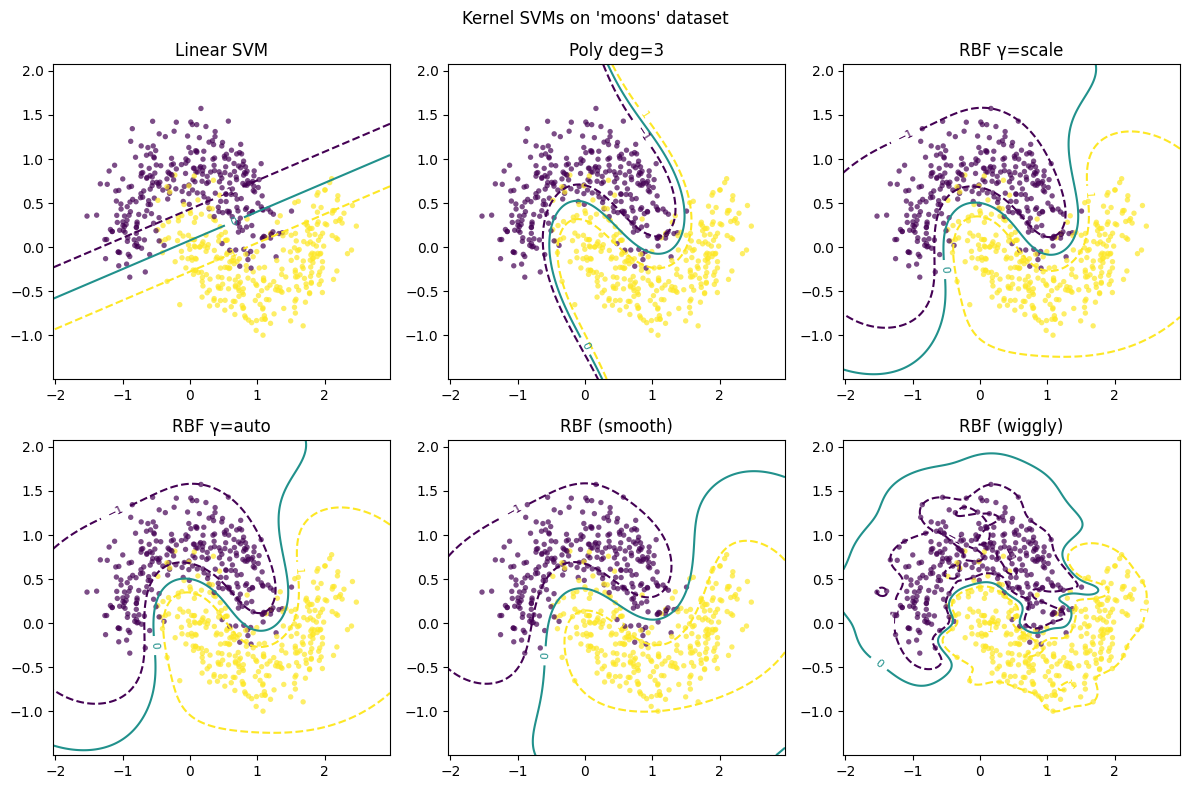

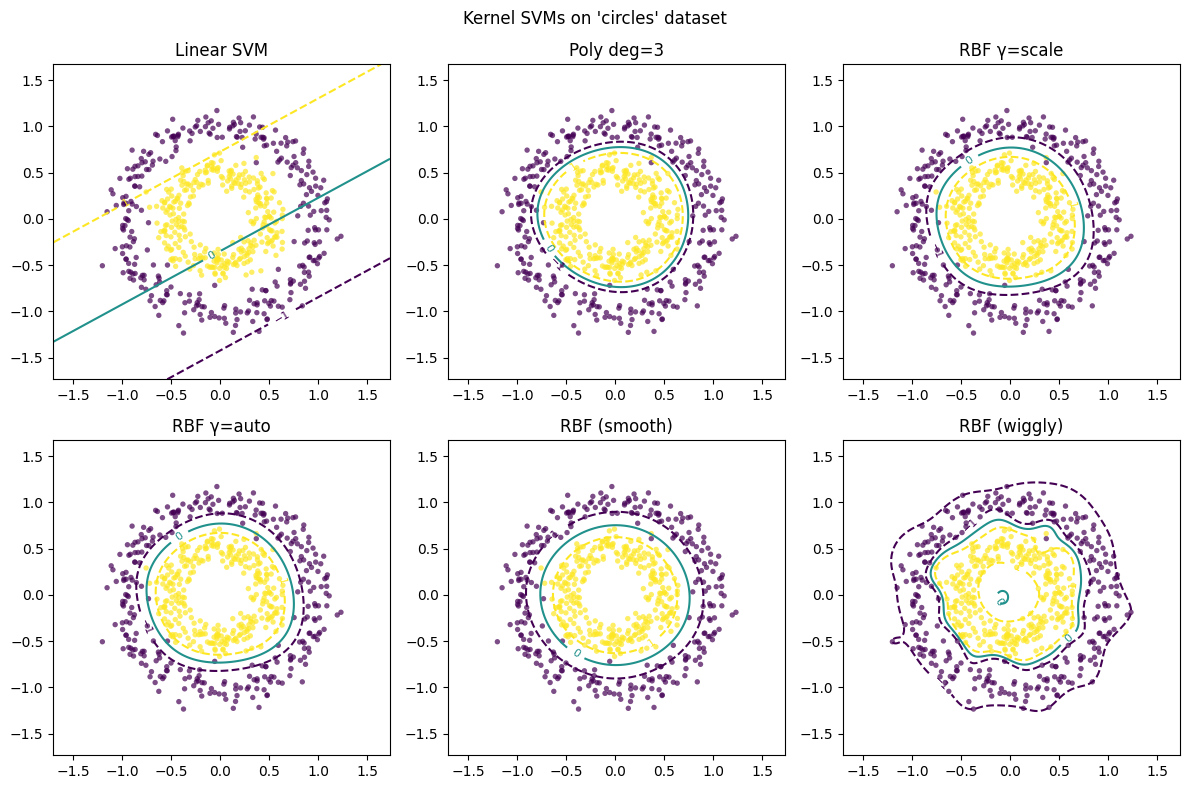

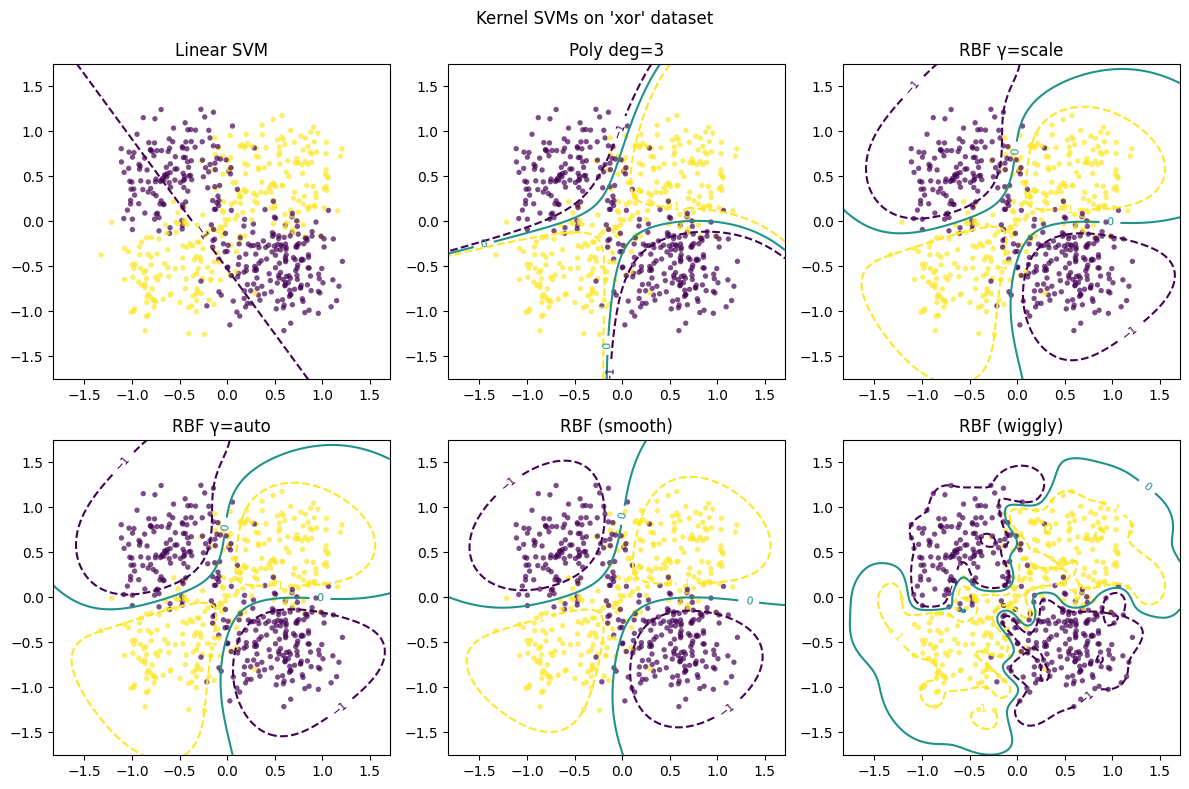

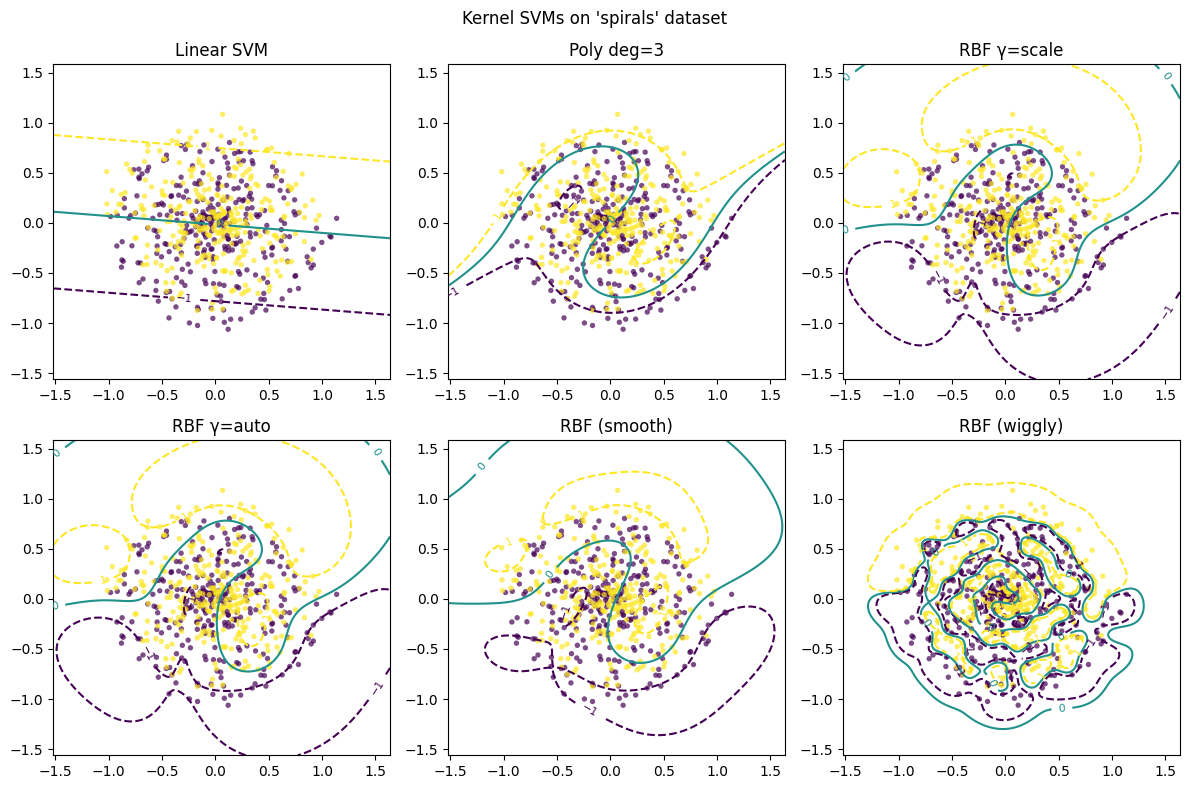

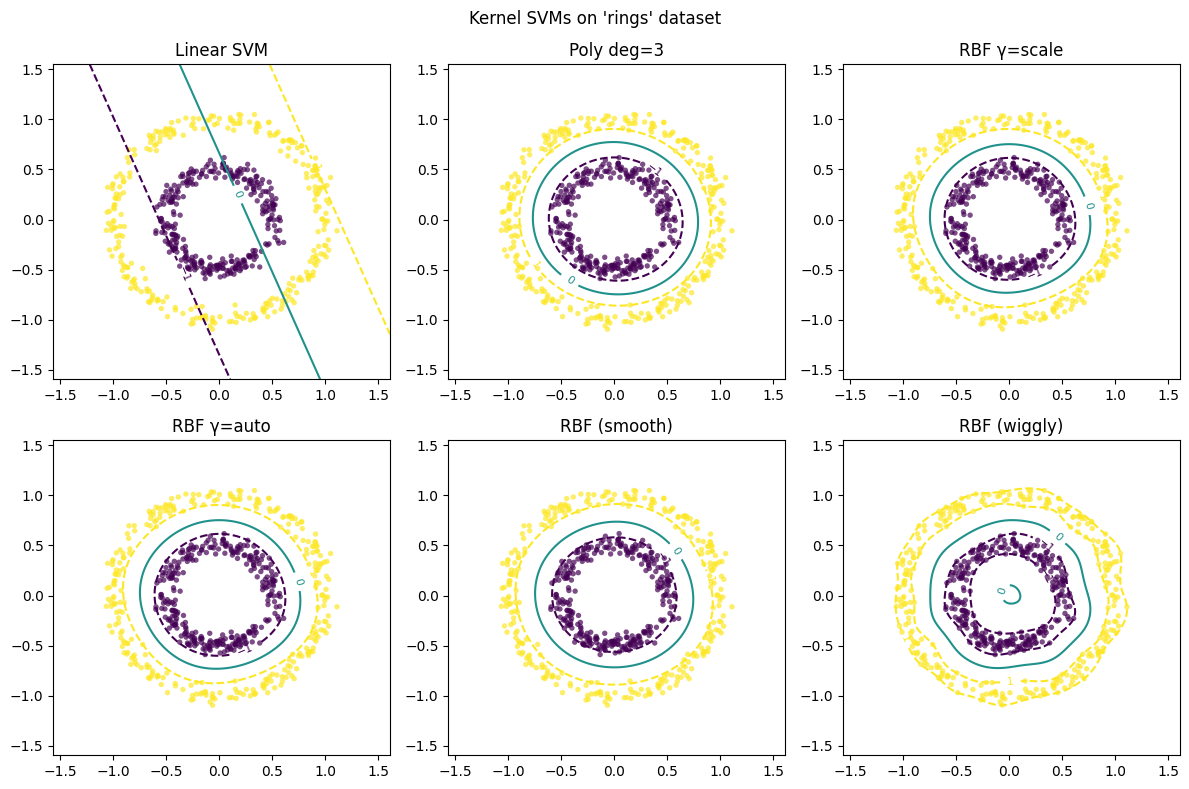

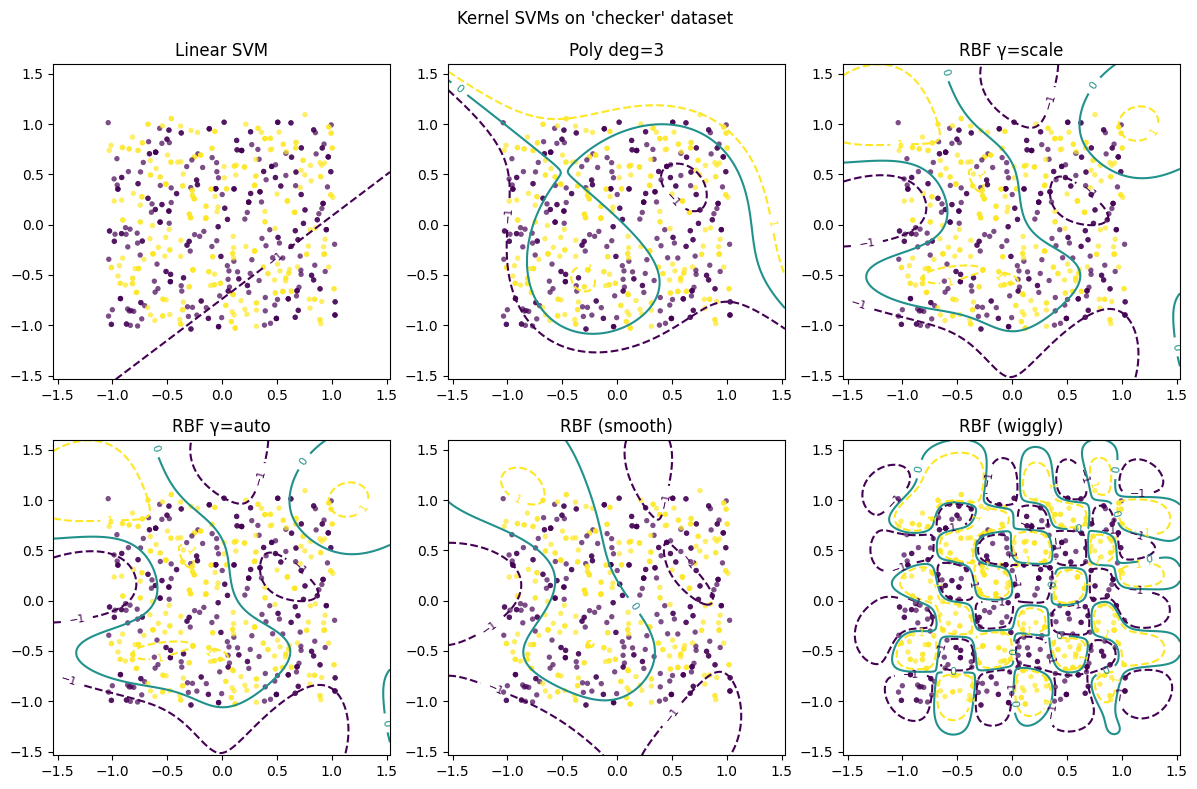

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from datasets_generation import load_dataset

def plot_decision_function(ax, model, X, y, title):
    # mesh
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # decision boundary & margins
    cs = ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=["--", "-", "--"])
    ax.clabel(cs, inline=1, fontsize=8)
    # points
    ax.scatter(X[:,0], X[:,1], c=y, s=15, alpha=0.7, edgecolor="none")
    ax.set_title(title)

# Models to compare
models = [
    ("Linear SVM", make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))),
    ("Poly deg=3", make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, C=5.0, coef0=1.0, gamma="scale"))),
    ("RBF γ=scale", make_pipeline(StandardScaler(), SVC(kernel="rbf", C=5.0, gamma="scale"))),
    ("RBF γ=auto",  make_pipeline(StandardScaler(), SVC(kernel="rbf", C=5.0, gamma="auto"))),
    ("RBF (smooth)", make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0, gamma=0.5))),
    ("RBF (wiggly)", make_pipeline(StandardScaler(), SVC(kernel="rbf", C=50.0, gamma=5.0))),
]

N = 600

rng = np.random.default_rng(0)

for DATASET in ["moons", "circles", "xor", "spirals", "rings", "checker"]:
    X, y = load_dataset(DATASET, N, rng)
    # your code that uses X, y here

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for ax, (name, clf) in zip(axes, models):
        clf.fit(X, y)
        plot_decision_function(ax, clf, X, y, name)

    plt.suptitle(f"Kernel SVMs on '{DATASET}' dataset")
    plt.tight_layout()
    plt.show()